# CNN Use-Case: MiR Detektion 

In diesem Use-Case beschäftigen wir uns mit dem Detektieren von Objekten in Bildern. Wie schon im [Storyboard](aiav.technikum-wien.at/) angesprochen befassen wir uns genauer gesagt mit dem Detektieren von einem mobilen Roboter, dem MiR100. 

</br>



Weitere Tutorials und ähnlicher aufbau: </br>
[Tensorflow2 Model Maker Tutorial](https://www.tensorflow.org/lite/tutorials/model_maker_object_detection) </br>
[Tensorflow2 Custom Objekt Detection Tutorial](https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb#scrollTo=35BJmtVpAP_n)

In [1]:
# Importieren der Bibliotheken
# können mittels der requirements.txt Datei installiert werden
import numpy as np
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector
import tensorflow as tf
import cv2
from PIL import Image

2022-06-20 07:55:03.969242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/master_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-06-20 07:55:03.969269: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Modell definieren

Tensorflow bietet eine Anzahl an verschiedenen Modellen welche für diverse Aufgaben geeignet sind. Die unten angeführte Tabelle zeigt eine Auswahl verschiedener Modelle und wozu sie eingesetzt werden können. 


| Aufgabengebiet | Modelle |
|---|---|
| Audio Klassifizierung  |  ['audio_browser_fft', 'audio_teachable_machine', 'audio_yamnet']  |  
|  Bild Klassifizierung  |  ['efficientnet_lite0',  'efficientnet_lite1',  'efficientnet_lite2',  'efficientnet_lite3',  'efficientnet_lite4',  'mobilenet_v2',  'resnet_50']  |  
|  Text Klassifizierung  |  ['bert_classifier', 'average_word_vec', 'mobilebert_classifier'] |  
|  ***-> Objekt Detektion***  |  *['efficientdet_lite0',  'efficientdet_lite1',  'efficientdet_lite2',  'efficientdet_lite3',  'efficientdet_lite4']*  |  
|  Fragen-Antwort-Modell  |  ['bert_qa', 'mobilebert_qa', 'mobilebert_qa_squad']  |  
|  Empfehlungs ML Modell  |  ['recommendation']  |  

Tabelle übernommen von [tflite_model_maker](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/model_spec)


### Objekt Detektion
Unser Use-Case beschäftigt sich mit der Objekt Detektion, weshalb wir ein "efficentdet_lite" Modell verwenden werden. Die Implementierung von Tensorflow basiert auf dem Modell des "[EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)"

Für unsere Anwendung kann also eines der unten angeführten Modelle ausgewählt werden. 

| Modell Architektur | Größe (MB)|	Latenz (ms) |	Durchschnittliche Genauigkeit </br> (COCO-Validierungsdatensatz) |
|---|---|---|---|
| EfficientDet-Lite0 | 4.4 	     |        37     |     	25.69% |
| EfficientDet-Lite1 | 5.8 	     |        49     |     	30.55% |
| EfficientDet-Lite2 | 7.2 	     |        69     |     	33.97% |
| EfficientDet-Lite3 | 11.4 	 |       116     |     	37.70% |
| EfficientDet-Lite4 | 19.9 	 |       260     |     	41.96% |
Tabelle übernommen von [Tensorflow Object Detection](https://www.tensorflow.org/lite/models/modify/model_maker/object_detection#quickstart)


In [2]:
# Definieren des Modells 
# um andere Modelle zu importieren kann das Argument der get()-Funktion angepasst werden. Z.B. zu 'efficientdet_lite0'
spec = model_spec.get('efficientdet_lite2')

2022-06-20 07:55:07.660253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 07:55:07.660570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/.local/lib/python3.8/site-packages/cv2/../../lib64:/home/moritz/master_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-06-20 07:55:07.660653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/.local/lib/python3.8/site-packages/cv2/../../lib64:/home/moritz/master_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/l

## Training
Um das Modell zu trainieren wird ein Datensatz benötigt. Hierfür verwenden wir das Pascal Voc xml Format. Dazu haben wir den Ordner [dataset](./dataset/) angelegt. In diesem Datensatz gibt es drei Unterordner. Für das Trainieren des Modells sind allerdings nur 2 davon relevant. Mit den Train und Validate Daten können wir das Modell Trainieren und Validieren. 

Zu jedem Bild gibt es eine entsprechende xml-Datei, welche die Informationen beinhaltet, wo sich auf dem Bild unser Objekt befindet. Um nun den Datensatz aufzubauen brauchen wir also ein Bild und eine xml-Datei. Ebenso werden wir in der folgenden Zelle noch die Klassennamen übergeben. 

Mit dem Datensatz kann anschließend das Modell trainiert werden. 



In [3]:
# Erstellen des Datensatzes

train_data = object_detector.DataLoader.from_pascal_voc(    # Einlesen des Trainingsdatensates
    'dataset/train',                                        # Bilddatein
    'dataset/train',                                        # xml-Beschreibungen
    ['MiR100']                                                 # Klassen 
)

val_data = object_detector.DataLoader.from_pascal_voc(      #Einlesen des Validirungsdatensatses
    'dataset/validate',                                     # Bilddatein
    'dataset/validate',                                     # xml-Beschreibung
    ['MiR100']                                                 # Klassen
)

INFO:tensorflow:Cache will be stored in /tmp/tmpptnrq092 with prefix filename 7bee435cfee6949ada7cad38d32e815e. Cache_prefix is /tmp/tmpptnrq092/7bee435cfee6949ada7cad38d32e815e
INFO:tensorflow:On image 0
INFO:tensorflow:Cache will be stored in /tmp/tmpqp_2vg4p with prefix filename 37bf5b72d4b8074ef6db5f4341392b61. Cache_prefix is /tmp/tmpqp_2vg4p/37bf5b72d4b8074ef6db5f4341392b61
INFO:tensorflow:On image 0


In [4]:
# Importieren des Modells und trainieren 

batch_size = 4      # Batch Size: Gibt die Anzahl der Bilder an welche in einer Itteration verwendet werden zum Trainieren.
epochs = 50          # Epochs: Ein Trainingszyklus bei dem alle Daten verwendet werden. 

# Model ist unsere Instanz. Wir trainieren mit "train_data" und validieren mit "val_data"
model = object_detector.create(train_data, model_spec=spec, batch_size=batch_size, train_whole_model=True, epochs=epochs, validation_data=val_data)
model.export(export_dir='.', tflite_filename='MiR_Model.tflite') # Wenn das Model fertig trainiert ist, können wir das hier abspeichern. Wir nennen es "MiR_Model"

INFO:tensorflow:Retraining the models...
Epoch 1/50


2022-06-20 07:55:19.401596: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - ETA: 0s - det_loss: 1.6024 - cls_loss: 1.0669 - box_loss: 0.0107 - reg_l2_loss: 0.0759 - loss: 1.6783 - learning_rate: 0.0066 - gradient_norm: 2.3166

2022-06-20 07:56:51.291324: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 97s 3s/step - det_loss: 1.5895 - cls_loss: 1.0584 - box_loss: 0.0106 - reg_l2_loss: 0.0759 - loss: 1.6653 - learning_rate: 0.0065 - gradient_norm: 2.3357 - val_det_loss: 1.1134 - val_cls_loss: 0.7281 - val_box_loss: 0.0077 - val_reg_l2_loss: 0.0759 - val_loss: 1.1892
Epoch 2/50
25/25 [==============================] - ETA: 0s - det_loss: 0.8221 - cls_loss: 0.5121 - box_loss: 0.0062 - reg_l2_loss: 0.0759 - loss: 0.8980 - learning_rate: 0.0050 - gradient_norm: 3.3008

2022-06-20 07:58:01.852854: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 69s 3s/step - det_loss: 0.8116 - cls_loss: 0.5044 - box_loss: 0.0061 - reg_l2_loss: 0.0759 - loss: 0.8875 - learning_rate: 0.0050 - gradient_norm: 3.2636 - val_det_loss: 0.5617 - val_cls_loss: 0.3688 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0759 - val_loss: 0.6376
Epoch 3/50
25/25 [==============================] - ETA: 0s - det_loss: 0.4992 - cls_loss: 0.3148 - box_loss: 0.0037 - reg_l2_loss: 0.0759 - loss: 0.5751 - learning_rate: 0.0050 - gradient_norm: 2.9273

2022-06-20 07:59:12.614287: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 71s 3s/step - det_loss: 0.4939 - cls_loss: 0.3115 - box_loss: 0.0036 - reg_l2_loss: 0.0759 - loss: 0.5698 - learning_rate: 0.0050 - gradient_norm: 2.8913 - val_det_loss: 0.4266 - val_cls_loss: 0.3012 - val_box_loss: 0.0025 - val_reg_l2_loss: 0.0759 - val_loss: 0.5025
Epoch 4/50
25/25 [==============================] - ETA: 0s - det_loss: 0.3963 - cls_loss: 0.2556 - box_loss: 0.0028 - reg_l2_loss: 0.0759 - loss: 0.4722 - learning_rate: 0.0049 - gradient_norm: 3.1264

2022-06-20 08:00:28.393434: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 75s 3s/step - det_loss: 0.3936 - cls_loss: 0.2545 - box_loss: 0.0028 - reg_l2_loss: 0.0759 - loss: 0.4695 - learning_rate: 0.0049 - gradient_norm: 3.0973 - val_det_loss: 0.3557 - val_cls_loss: 0.2445 - val_box_loss: 0.0022 - val_reg_l2_loss: 0.0759 - val_loss: 0.4317
Epoch 5/50
25/25 [==============================] - ETA: 0s - det_loss: 0.3306 - cls_loss: 0.2129 - box_loss: 0.0024 - reg_l2_loss: 0.0759 - loss: 0.4065 - learning_rate: 0.0049 - gradient_norm: 2.9871

2022-06-20 08:01:37.333989: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.755
 Average Recall

2022-06-20 08:02:50.656506: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 68s 3s/step - det_loss: 0.2945 - cls_loss: 0.2001 - box_loss: 0.0019 - reg_l2_loss: 0.0759 - loss: 0.3705 - learning_rate: 0.0048 - gradient_norm: 2.8130 - val_det_loss: 0.2701 - val_cls_loss: 0.1874 - val_box_loss: 0.0017 - val_reg_l2_loss: 0.0759 - val_loss: 0.3460
Epoch 7/50
25/25 [==============================] - ETA: 0s - det_loss: 0.2702 - cls_loss: 0.1874 - box_loss: 0.0017 - reg_l2_loss: 0.0759 - loss: 0.3461 - learning_rate: 0.0048 - gradient_norm: 3.0029

2022-06-20 08:03:58.817091: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 68s 3s/step - det_loss: 0.2694 - cls_loss: 0.1868 - box_loss: 0.0017 - reg_l2_loss: 0.0759 - loss: 0.3454 - learning_rate: 0.0048 - gradient_norm: 3.0019 - val_det_loss: 0.2715 - val_cls_loss: 0.1646 - val_box_loss: 0.0021 - val_reg_l2_loss: 0.0759 - val_loss: 0.3474
Epoch 8/50
25/25 [==============================] - ETA: 0s - det_loss: 0.2411 - cls_loss: 0.1720 - box_loss: 0.0014 - reg_l2_loss: 0.0760 - loss: 0.3171 - learning_rate: 0.0047 - gradient_norm: 3.0528

2022-06-20 08:05:10.198240: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 72s 3s/step - det_loss: 0.2387 - cls_loss: 0.1704 - box_loss: 0.0014 - reg_l2_loss: 0.0760 - loss: 0.3147 - learning_rate: 0.0047 - gradient_norm: 3.0269 - val_det_loss: 0.2943 - val_cls_loss: 0.2195 - val_box_loss: 0.0015 - val_reg_l2_loss: 0.0760 - val_loss: 0.3703
Epoch 9/50
25/25 [==============================] - ETA: 0s - det_loss: 0.2384 - cls_loss: 0.1657 - box_loss: 0.0015 - reg_l2_loss: 0.0760 - loss: 0.3144 - learning_rate: 0.0046 - gradient_norm: 3.3348

2022-06-20 08:06:21.206725: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 71s 3s/step - det_loss: 0.2359 - cls_loss: 0.1642 - box_loss: 0.0014 - reg_l2_loss: 0.0760 - loss: 0.3119 - learning_rate: 0.0046 - gradient_norm: 3.2774 - val_det_loss: 0.2457 - val_cls_loss: 0.1791 - val_box_loss: 0.0013 - val_reg_l2_loss: 0.0760 - val_loss: 0.3217
Epoch 10/50
25/25 [==============================] - ETA: 0s - det_loss: 0.2270 - cls_loss: 0.1550 - box_loss: 0.0014 - reg_l2_loss: 0.0760 - loss: 0.3030 - learning_rate: 0.0046 - gradient_norm: 2.7155

2022-06-20 08:07:29.171511: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.825
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.850
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.885
 Average Recall

2022-06-20 08:08:40.376476: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 68s 3s/step - det_loss: 0.1950 - cls_loss: 0.1391 - box_loss: 0.0011 - reg_l2_loss: 0.0760 - loss: 0.2710 - learning_rate: 0.0045 - gradient_norm: 2.2322 - val_det_loss: 0.2070 - val_cls_loss: 0.1613 - val_box_loss: 9.1436e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2829
Epoch 12/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1888 - cls_loss: 0.1364 - box_loss: 0.0010 - reg_l2_loss: 0.0760 - loss: 0.2648 - learning_rate: 0.0044 - gradient_norm: 2.5514

2022-06-20 08:09:48.530014: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 68s 3s/step - det_loss: 0.1910 - cls_loss: 0.1377 - box_loss: 0.0011 - reg_l2_loss: 0.0760 - loss: 0.2670 - learning_rate: 0.0044 - gradient_norm: 2.6054 - val_det_loss: 0.1853 - val_cls_loss: 0.1304 - val_box_loss: 0.0011 - val_reg_l2_loss: 0.0760 - val_loss: 0.2612
Epoch 13/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1851 - cls_loss: 0.1285 - box_loss: 0.0011 - reg_l2_loss: 0.0760 - loss: 0.2611 - learning_rate: 0.0042 - gradient_norm: 2.3668

2022-06-20 08:10:56.839871: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 69s 3s/step - det_loss: 0.1835 - cls_loss: 0.1278 - box_loss: 0.0011 - reg_l2_loss: 0.0760 - loss: 0.2595 - learning_rate: 0.0042 - gradient_norm: 2.3390 - val_det_loss: 0.1475 - val_cls_loss: 0.1238 - val_box_loss: 4.7400e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2235
Epoch 14/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1844 - cls_loss: 0.1333 - box_loss: 0.0010 - reg_l2_loss: 0.0760 - loss: 0.2604 - learning_rate: 0.0041 - gradient_norm: 2.5920  

2022-06-20 08:12:05.883410: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 69s 3s/step - det_loss: 0.1840 - cls_loss: 0.1325 - box_loss: 0.0010 - reg_l2_loss: 0.0760 - loss: 0.2600 - learning_rate: 0.0041 - gradient_norm: 2.6097 - val_det_loss: 0.1400 - val_cls_loss: 0.1102 - val_box_loss: 5.9641e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2160
Epoch 15/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1879 - cls_loss: 0.1369 - box_loss: 0.0010 - reg_l2_loss: 0.0760 - loss: 0.2639 - learning_rate: 0.0040 - gradient_norm: 2.7287

2022-06-20 08:13:14.649873: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.815
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.840
 Average Recall

2022-06-20 08:14:25.274551: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 68s 3s/step - det_loss: 0.1720 - cls_loss: 0.1237 - box_loss: 9.6609e-04 - reg_l2_loss: 0.0760 - loss: 0.2480 - learning_rate: 0.0039 - gradient_norm: 2.5066 - val_det_loss: 0.1517 - val_cls_loss: 0.1083 - val_box_loss: 8.6821e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2277
Epoch 17/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1620 - cls_loss: 0.1173 - box_loss: 8.9459e-04 - reg_l2_loss: 0.0760 - loss: 0.2380 - learning_rate: 0.0037 - gradient_norm: 2.1266

2022-06-20 08:15:37.448120: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 73s 3s/step - det_loss: 0.1654 - cls_loss: 0.1196 - box_loss: 9.1596e-04 - reg_l2_loss: 0.0760 - loss: 0.2414 - learning_rate: 0.0037 - gradient_norm: 2.1655 - val_det_loss: 0.1299 - val_cls_loss: 0.0972 - val_box_loss: 6.5355e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2059
Epoch 18/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1595 - cls_loss: 0.1182 - box_loss: 8.2690e-04 - reg_l2_loss: 0.0760 - loss: 0.2355 - learning_rate: 0.0036 - gradient_norm: 2.1954

2022-06-20 08:16:58.568492: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 80s 3s/step - det_loss: 0.1584 - cls_loss: 0.1180 - box_loss: 8.0778e-04 - reg_l2_loss: 0.0760 - loss: 0.2344 - learning_rate: 0.0036 - gradient_norm: 2.1641 - val_det_loss: 0.1297 - val_cls_loss: 0.0977 - val_box_loss: 6.4012e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2057
Epoch 19/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1401 - cls_loss: 0.1057 - box_loss: 6.8928e-04 - reg_l2_loss: 0.0760 - loss: 0.2161 - learning_rate: 0.0034 - gradient_norm: 1.8409

2022-06-20 08:18:29.020061: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 91s 4s/step - det_loss: 0.1405 - cls_loss: 0.1060 - box_loss: 6.9176e-04 - reg_l2_loss: 0.0760 - loss: 0.2165 - learning_rate: 0.0034 - gradient_norm: 1.8408 - val_det_loss: 0.1137 - val_cls_loss: 0.0920 - val_box_loss: 4.3249e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1897
Epoch 20/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1426 - cls_loss: 0.1053 - box_loss: 7.4520e-04 - reg_l2_loss: 0.0760 - loss: 0.2186 - learning_rate: 0.0033 - gradient_norm: 1.9974

2022-06-20 08:19:50.404739: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.871
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.885
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.895
 Average Recall

2022-06-20 08:21:04.253546: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 71s 3s/step - det_loss: 0.1403 - cls_loss: 0.1010 - box_loss: 7.8741e-04 - reg_l2_loss: 0.0760 - loss: 0.2163 - learning_rate: 0.0031 - gradient_norm: 2.5360 - val_det_loss: 0.1033 - val_cls_loss: 0.0845 - val_box_loss: 3.7451e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1793
Epoch 22/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1462 - cls_loss: 0.1107 - box_loss: 7.1047e-04 - reg_l2_loss: 0.0760 - loss: 0.2222 - learning_rate: 0.0030 - gradient_norm: 2.1085

2022-06-20 08:22:11.139684: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1463 - cls_loss: 0.1110 - box_loss: 7.0621e-04 - reg_l2_loss: 0.0760 - loss: 0.2223 - learning_rate: 0.0030 - gradient_norm: 2.1061 - val_det_loss: 0.1315 - val_cls_loss: 0.1045 - val_box_loss: 5.3867e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.2075
Epoch 23/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1328 - cls_loss: 0.0972 - box_loss: 7.1094e-04 - reg_l2_loss: 0.0760 - loss: 0.2088 - learning_rate: 0.0028 - gradient_norm: 2.1506

2022-06-20 08:23:17.797415: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1325 - cls_loss: 0.0969 - box_loss: 7.1177e-04 - reg_l2_loss: 0.0760 - loss: 0.2085 - learning_rate: 0.0028 - gradient_norm: 2.1604 - val_det_loss: 0.1043 - val_cls_loss: 0.0874 - val_box_loss: 3.3832e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1803
Epoch 24/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1398 - cls_loss: 0.1054 - box_loss: 6.8813e-04 - reg_l2_loss: 0.0760 - loss: 0.2158 - learning_rate: 0.0027 - gradient_norm: 2.3914

2022-06-20 08:24:24.164842: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 66s 3s/step - det_loss: 0.1415 - cls_loss: 0.1063 - box_loss: 7.0468e-04 - reg_l2_loss: 0.0760 - loss: 0.2175 - learning_rate: 0.0027 - gradient_norm: 2.4327 - val_det_loss: 0.0990 - val_cls_loss: 0.0787 - val_box_loss: 4.0643e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1750
Epoch 25/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1379 - cls_loss: 0.1042 - box_loss: 6.7543e-04 - reg_l2_loss: 0.0760 - loss: 0.2139 - learning_rate: 0.0025 - gradient_norm: 2.0964

2022-06-20 08:25:30.391555: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.865
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.885
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.915
 Average Recall

2022-06-20 08:26:40.934391: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1229 - cls_loss: 0.0959 - box_loss: 5.3947e-04 - reg_l2_loss: 0.0760 - loss: 0.1989 - learning_rate: 0.0023 - gradient_norm: 1.9323 - val_det_loss: 0.1179 - val_cls_loss: 0.0867 - val_box_loss: 6.2416e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1939
Epoch 27/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1240 - cls_loss: 0.0979 - box_loss: 5.2288e-04 - reg_l2_loss: 0.0760 - loss: 0.2000 - learning_rate: 0.0022 - gradient_norm: 1.7138

2022-06-20 08:27:53.814048: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 73s 3s/step - det_loss: 0.1238 - cls_loss: 0.0976 - box_loss: 5.2468e-04 - reg_l2_loss: 0.0760 - loss: 0.1998 - learning_rate: 0.0022 - gradient_norm: 1.7474 - val_det_loss: 0.0976 - val_cls_loss: 0.0762 - val_box_loss: 4.2834e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1736
Epoch 28/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1233 - cls_loss: 0.0965 - box_loss: 5.3613e-04 - reg_l2_loss: 0.0760 - loss: 0.1993 - learning_rate: 0.0020 - gradient_norm: 1.8942

2022-06-20 08:29:03.110537: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 69s 3s/step - det_loss: 0.1225 - cls_loss: 0.0957 - box_loss: 5.3473e-04 - reg_l2_loss: 0.0760 - loss: 0.1985 - learning_rate: 0.0020 - gradient_norm: 1.8822 - val_det_loss: 0.0882 - val_cls_loss: 0.0732 - val_box_loss: 3.0010e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1642
Epoch 29/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1178 - cls_loss: 0.0913 - box_loss: 5.2983e-04 - reg_l2_loss: 0.0760 - loss: 0.1938 - learning_rate: 0.0019 - gradient_norm: 1.5939

2022-06-20 08:30:09.405207: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 66s 3s/step - det_loss: 0.1171 - cls_loss: 0.0909 - box_loss: 5.2381e-04 - reg_l2_loss: 0.0760 - loss: 0.1930 - learning_rate: 0.0019 - gradient_norm: 1.5826 - val_det_loss: 0.0951 - val_cls_loss: 0.0791 - val_box_loss: 3.2072e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1711
Epoch 30/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1286 - cls_loss: 0.0984 - box_loss: 6.0452e-04 - reg_l2_loss: 0.0760 - loss: 0.2046 - learning_rate: 0.0017 - gradient_norm: 2.1449

2022-06-20 08:31:15.682139: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.907
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.925
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.945
 Average Recall

2022-06-20 08:32:27.310497: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 69s 3s/step - det_loss: 0.1179 - cls_loss: 0.0923 - box_loss: 5.1366e-04 - reg_l2_loss: 0.0760 - loss: 0.1939 - learning_rate: 0.0016 - gradient_norm: 1.8560 - val_det_loss: 0.0786 - val_cls_loss: 0.0689 - val_box_loss: 1.9494e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1546
Epoch 32/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1167 - cls_loss: 0.0929 - box_loss: 4.7663e-04 - reg_l2_loss: 0.0760 - loss: 0.1927 - learning_rate: 0.0014 - gradient_norm: 1.7436

2022-06-20 08:33:33.886451: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1177 - cls_loss: 0.0936 - box_loss: 4.8333e-04 - reg_l2_loss: 0.0760 - loss: 0.1937 - learning_rate: 0.0014 - gradient_norm: 1.7718 - val_det_loss: 0.0835 - val_cls_loss: 0.0719 - val_box_loss: 2.3249e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1595
Epoch 33/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1138 - cls_loss: 0.0899 - box_loss: 4.7825e-04 - reg_l2_loss: 0.0760 - loss: 0.1898 - learning_rate: 0.0013 - gradient_norm: 1.6591

2022-06-20 08:34:45.431355: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 71s 3s/step - det_loss: 0.1126 - cls_loss: 0.0891 - box_loss: 4.7074e-04 - reg_l2_loss: 0.0760 - loss: 0.1886 - learning_rate: 0.0013 - gradient_norm: 1.6442 - val_det_loss: 0.0906 - val_cls_loss: 0.0753 - val_box_loss: 3.0587e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1666
Epoch 34/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1156 - cls_loss: 0.0892 - box_loss: 5.2794e-04 - reg_l2_loss: 0.0760 - loss: 0.1915 - learning_rate: 0.0011 - gradient_norm: 2.2046

2022-06-20 08:35:56.022142: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 70s 3s/step - det_loss: 0.1146 - cls_loss: 0.0887 - box_loss: 5.1958e-04 - reg_l2_loss: 0.0760 - loss: 0.1906 - learning_rate: 0.0011 - gradient_norm: 2.1669 - val_det_loss: 0.0780 - val_cls_loss: 0.0693 - val_box_loss: 1.7339e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1540
Epoch 35/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1193 - cls_loss: 0.0926 - box_loss: 5.3374e-04 - reg_l2_loss: 0.0760 - loss: 0.1953 - learning_rate: 0.0010 - gradient_norm: 1.9457

2022-06-20 08:37:03.053004: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.901
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.915
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.935
 Average Recall

2022-06-20 08:38:12.147824: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1095 - cls_loss: 0.0848 - box_loss: 4.9340e-04 - reg_l2_loss: 0.0760 - loss: 0.1855 - learning_rate: 8.7991e-04 - gradient_norm: 1.6644 - val_det_loss: 0.0779 - val_cls_loss: 0.0687 - val_box_loss: 1.8384e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1539
Epoch 37/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1055 - cls_loss: 0.0856 - box_loss: 3.9851e-04 - reg_l2_loss: 0.0760 - loss: 0.1815 - learning_rate: 7.6339e-04 - gradient_norm: 1.5840

2022-06-20 08:39:19.868130: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1062 - cls_loss: 0.0856 - box_loss: 4.1320e-04 - reg_l2_loss: 0.0760 - loss: 0.1822 - learning_rate: 7.6129e-04 - gradient_norm: 1.6056 - val_det_loss: 0.0791 - val_cls_loss: 0.0701 - val_box_loss: 1.7927e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1550
Epoch 38/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1099 - cls_loss: 0.0850 - box_loss: 4.9813e-04 - reg_l2_loss: 0.0760 - loss: 0.1859 - learning_rate: 6.5178e-04 - gradient_norm: 1.6133

2022-06-20 08:40:29.526772: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 70s 3s/step - det_loss: 0.1088 - cls_loss: 0.0842 - box_loss: 4.9243e-04 - reg_l2_loss: 0.0760 - loss: 0.1848 - learning_rate: 6.4981e-04 - gradient_norm: 1.6062 - val_det_loss: 0.0752 - val_cls_loss: 0.0666 - val_box_loss: 1.7190e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1512
Epoch 39/50
25/25 [==============================] - ETA: 0s - det_loss: 0.0995 - cls_loss: 0.0797 - box_loss: 3.9644e-04 - reg_l2_loss: 0.0760 - loss: 0.1755 - learning_rate: 5.4776e-04 - gradient_norm: 1.6578

2022-06-20 08:41:35.943958: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 66s 3s/step - det_loss: 0.0994 - cls_loss: 0.0796 - box_loss: 3.9724e-04 - reg_l2_loss: 0.0760 - loss: 0.1754 - learning_rate: 5.4593e-04 - gradient_norm: 1.6827 - val_det_loss: 0.0795 - val_cls_loss: 0.0677 - val_box_loss: 2.3586e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1555
Epoch 40/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1147 - cls_loss: 0.0930 - box_loss: 4.3317e-04 - reg_l2_loss: 0.0760 - loss: 0.1907 - learning_rate: 4.5176e-04 - gradient_norm: 1.8663

2022-06-20 08:42:41.704000: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.910
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.925
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.955
 Average Recall

2022-06-20 08:43:53.932710: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 69s 3s/step - det_loss: 0.1141 - cls_loss: 0.0924 - box_loss: 4.3521e-04 - reg_l2_loss: 0.0760 - loss: 0.1901 - learning_rate: 3.6266e-04 - gradient_norm: 1.9150 - val_det_loss: 0.0770 - val_cls_loss: 0.0683 - val_box_loss: 1.7477e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1530
Epoch 42/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1142 - cls_loss: 0.0913 - box_loss: 4.5738e-04 - reg_l2_loss: 0.0760 - loss: 0.1901 - learning_rate: 2.8536e-04 - gradient_norm: 1.7568

2022-06-20 08:45:01.812508: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 68s 3s/step - det_loss: 0.1142 - cls_loss: 0.0913 - box_loss: 4.5850e-04 - reg_l2_loss: 0.0760 - loss: 0.1902 - learning_rate: 2.8402e-04 - gradient_norm: 1.7488 - val_det_loss: 0.0737 - val_cls_loss: 0.0661 - val_box_loss: 1.5194e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1497
Epoch 43/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1058 - cls_loss: 0.0855 - box_loss: 4.0623e-04 - reg_l2_loss: 0.0760 - loss: 0.1817 - learning_rate: 2.1566e-04 - gradient_norm: 1.5384

2022-06-20 08:46:30.747677: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 89s 4s/step - det_loss: 0.1056 - cls_loss: 0.0853 - box_loss: 4.0671e-04 - reg_l2_loss: 0.0760 - loss: 0.1816 - learning_rate: 2.1448e-04 - gradient_norm: 1.5226 - val_det_loss: 0.0770 - val_cls_loss: 0.0677 - val_box_loss: 1.8580e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1530
Epoch 44/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1103 - cls_loss: 0.0880 - box_loss: 4.4630e-04 - reg_l2_loss: 0.0760 - loss: 0.1863 - learning_rate: 1.5534e-04 - gradient_norm: 1.6194

2022-06-20 08:47:56.084810: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 86s 3s/step - det_loss: 0.1095 - cls_loss: 0.0875 - box_loss: 4.3937e-04 - reg_l2_loss: 0.0760 - loss: 0.1855 - learning_rate: 1.5434e-04 - gradient_norm: 1.6096 - val_det_loss: 0.0752 - val_cls_loss: 0.0668 - val_box_loss: 1.6787e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1512
Epoch 45/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1057 - cls_loss: 0.0879 - box_loss: 3.5663e-04 - reg_l2_loss: 0.0760 - loss: 0.1817 - learning_rate: 1.0465e-04 - gradient_norm: 1.5352

2022-06-20 08:49:03.167958: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.919
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.950
 Average Recall

2022-06-20 08:50:12.203727: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 66s 3s/step - det_loss: 0.1090 - cls_loss: 0.0875 - box_loss: 4.3134e-04 - reg_l2_loss: 0.0760 - loss: 0.1850 - learning_rate: 6.3178e-05 - gradient_norm: 1.6882 - val_det_loss: 0.0754 - val_cls_loss: 0.0672 - val_box_loss: 1.6362e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1514
Epoch 47/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1095 - cls_loss: 0.0870 - box_loss: 4.4879e-04 - reg_l2_loss: 0.0760 - loss: 0.1855 - learning_rate: 3.2981e-05 - gradient_norm: 1.7486

2022-06-20 08:51:18.704451: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 67s 3s/step - det_loss: 0.1086 - cls_loss: 0.0866 - box_loss: 4.4138e-04 - reg_l2_loss: 0.0760 - loss: 0.1846 - learning_rate: 3.2534e-05 - gradient_norm: 1.7219 - val_det_loss: 0.0764 - val_cls_loss: 0.0680 - val_box_loss: 1.6921e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1524
Epoch 48/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1060 - cls_loss: 0.0848 - box_loss: 4.2469e-04 - reg_l2_loss: 0.0760 - loss: 0.1820 - learning_rate: 1.2288e-05 - gradient_norm: 1.5141

2022-06-20 08:52:25.067670: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 66s 3s/step - det_loss: 0.1069 - cls_loss: 0.0856 - box_loss: 4.2523e-04 - reg_l2_loss: 0.0760 - loss: 0.1829 - learning_rate: 1.2029e-05 - gradient_norm: 1.5225 - val_det_loss: 0.0763 - val_cls_loss: 0.0679 - val_box_loss: 1.6918e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1523
Epoch 49/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1015 - cls_loss: 0.0829 - box_loss: 3.7127e-04 - reg_l2_loss: 0.0760 - loss: 0.1774 - learning_rate: 1.8165e-06 - gradient_norm: 1.6585

2022-06-20 08:53:30.813277: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


25/25 [==============================] - 66s 3s/step - det_loss: 0.1011 - cls_loss: 0.0825 - box_loss: 3.7042e-04 - reg_l2_loss: 0.0760 - loss: 0.1770 - learning_rate: 1.7469e-06 - gradient_norm: 1.6457 - val_det_loss: 0.0762 - val_cls_loss: 0.0677 - val_box_loss: 1.6991e-04 - val_reg_l2_loss: 0.0760 - val_loss: 0.1522
Epoch 50/50
25/25 [==============================] - ETA: 0s - det_loss: 0.1032 - cls_loss: 0.0822 - box_loss: 4.2095e-04 - reg_l2_loss: 0.0760 - loss: 0.1792 - learning_rate: 1.6111e-06 - gradient_norm: 1.5377

2022-06-20 08:54:36.797406: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.918
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.965
 Average Recall

2022-06-20 08:54:43.820360: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpn_j_os7e/assets


INFO:tensorflow:Assets written to: /tmp/tmpn_j_os7e/assets
2022-06-20 08:55:09.749204: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2022-06-20 08:55:16.918759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-20 08:55:16.918796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-20 08:55:16.919474: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpn_j_os7e
2022-06-20 08:55:17.035867: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-20 08:55:17.035898: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpn_j_os7e
2022-06-20 08:55:17.404206: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel

Estimated count of arithmetic ops: 6.066 G  ops, equivalently 3.033 G  MACs
Estimated count of arithmetic ops: 6.066 G  ops, equivalently 3.033 G  MACs


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0
2022-06-20 08:56:17.435667: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1963] Estimated count of arithmetic ops: 6.066 G  ops, equivalently 3.033 G  MACs



INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpc9alyaeb/labelmap.txt.


INFO:tensorflow:Saving labels in /tmp/tmpc9alyaeb/labelmap.txt.


INFO:tensorflow:TensorFlow Lite model exported successfully: ./MiR_Model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./MiR_Model.tflite


In [5]:
results = model.evaluate(val_data)

2022-06-20 08:56:19.073869: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


1/1 [==============================] - 6s 6s/step

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
Converting ndarray to lists...
(2000, 7)
0/2000
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.918
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.935
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

## Implementierung
In den anschließenden Zellen wollen wir nun das Modell anwenden. 

Als erstes kommt hier der dritte Ordner im [dataset](./dataset/) Ordner ins Spiel. Der Ordner [test](/dataset/test/) beinhaltet neue Bilder, die das Modell noch nie gesehen hat. Wir können nun jedes Bild dem Modell zeigen und uns anschauen ob es denn unser Objekt wirklich richtig erkennt. 

Als zweites wollen wir das ganze dynamischer Testen. Wir verwenden erneut eine OpenCV Webcam-Implementierung. Da ein Video nur aus einer Abfolge von Bildern besteht, können wir einfach ein Bild nach dem anderen abgreifen und unserem Modell zeigen. 

### HILFSFUNKTIONEN - TODO Anpassen


Sourcecode: https://www.tensorflow.org/lite/models/modify/model_maker/object_detection#optional_test_the_tflite_model_on_your_image

In [6]:
############################## HILFSFUNKTIONEN ############################## 
# https://www.tensorflow.org/lite/models/modify/model_maker/object_detection#optional_test_the_tflite_model_on_your_image

# Labels in eine Liste speichern. 
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map

for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Eine Farbe wird den Klassen zugeordnet, wird für die darstellung verwendet 
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

# Bild Verarbeitung und Anpassung (wird von "run_odt_and_draw_results()" aufgerufen)
def preprocess_image(image_path, input_size):
  img = tf.io.read_file(image_path)                   # Laden der Bilddatei
  img = tf.io.decode_image(img, channels=3)           # "decode_image" gibt eine 3-Dimensionale Form zurück. Entspricht den 3 Farbkanälen RGB 
  img = tf.image.convert_image_dtype(img, tf.uint8)   # Umwandeln zu UINT8 (Darstellung der Farbkanäle als 8 Bit)
  original_image = img                                # Originalbild Merken
  resized_img = tf.image.resize(img, input_size)      # Originalbld in größe des Netzwerkeingangs umwandeln
  resized_img = resized_img[tf.newaxis, :]            # Umformen
  resized_img = tf.cast(resized_img, dtype=tf.uint8)  # Konvertieren zu UINT8 
  return resized_img, original_image                  # Zurückgeben beider Bilder 

# Objekt Detektion (wird von "run_odt_and_draw_results()" aufgerufen)
def detect_objects(interpreter, image, threshold):

  signature_fn = interpreter.get_signature_runner()   # Modelinformationen werden abgerufen 
  output = signature_fn(images=image)                 # Das Eingangsbild wird dem Model gezeigt. "Detektion"

  # Die Ergebnisse der Detektion werden verarbeitet
  count = int(np.squeeze(output['output_0']))         # Anzahl der gefundenen Objekte
  scores = np.squeeze(output['output_1'])             # Sicherheit zu den gefundenen Objekten
  classes = np.squeeze(output['output_2'])            # Zu welcher Klasse die gefundenen Objekte gehören
  boxes = np.squeeze(output['output_3'])              # relativen Koordinaten zu den Objekten 

  results = []                      # Liste an Objektinformationen (Dictioary für die Objekte)
  for i in range(count):            # Über jedes Objekt wird Itteriert 
    if scores[i] >= threshold:      # Wird ein gewisser Threshold überschritten, dann wird das Objekt gezählt. (z.B. Über 50% Sicherheit)
      result = {                    # Eintragen der gewollten Ergebnisse
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  
  return results      # Zurückgeben der Ergebnisse 




# Objekt Detektion 
#   1) Preprocess
#   2) Detektieren
#   3) Bounding Box einzeichnen

def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):


  # 1) Preprocess
  # Aus dem Interpreter (Modellinformationen) wird die notwendige Bildgröße geladen, auf die das Modell trainiert ist. 
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']
  # Das zu verarbeitende Bild wird geladen und an das trainierte Modell angepasst. 
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )
  

  # 2) Detektion
  # Hier wird das angepasste Bild verwendet um die Objektdetektion durchzuführen 
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)


  # 3) Bounding Box einzeichnen
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Hier werden die relativen Koordinaten (Ergebnis der detect_objects funktion) in die absoluten Koordinaten des Originalbildes umgeformt
    ymin, xmin, ymax, xmax = obj['bounding_box'] 
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Klassenindex des Objektes festlegen 
    class_id = int(obj['class_id'])

    # Bounding Box einzeichnen und ein Label dazu schreiben 
    color = [int(c) for c in COLORS[class_id]]                              # Aus der erstellten Farbpalette wird eine Farbe gewählt
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)  # OpenCV Rechteck Funktion für das einzeichnen der Bounding box
    # Label wird angepasst um sichtbarkeit zu garantieren   
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15                          # Offset Handling
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)     # Das Label besteht aus dem Klassennamen und der Sicherheit
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)                            # OpenCV Textfunktion für das auftragen des Labels im Originalbild

  # Das Bild inklusive Beschriftung wird zurückgeliefert 
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

### Test

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


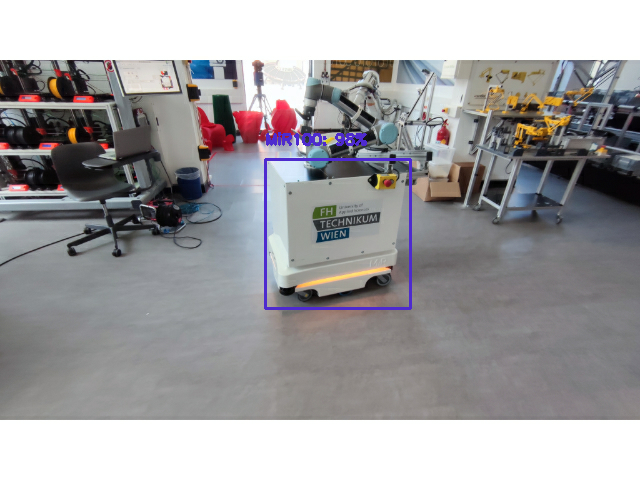

In [7]:
# Testen des Modells mit Test-Bildern
img_file = "dataset/test/001.jpg"       # Pfad für ein Testbild
model_path = 'MiR_Model.tflite'         # Pfad für das Modell
det_threshold = 0.5                     # Threshold - gibt an ab wie viel Prozent eine Detektion als "Korrekt" gezählt werden kann

# Bildeinladen 
im = Image.open(img_file).convert('RGB')
im.thumbnail((512, 512), Image.ANTIALIAS)

# Laden des trainierten Modells
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Ausführen der Hilfsfunktionen für das Detektieren der Objekte
detection_result_image = run_odt_and_draw_results(
    img_file,
    interpreter,
    threshold=det_threshold
)

# Anzeigen des Ergebnis 
Image.fromarray(detection_result_image)


## Kamera implementieren

In [9]:
import cv2

cv2.namedWindow("cam",0)    # Ein Fenster öffnen um den Videostream auszugeben
filename = 'test03.mp4'
cap = cv2.VideoCapture("dataset/test/" + filename)   # Webcam einbinden und Stream öffnen
output_file = 'output/result_MiR_' + filename

# Video encoder
size = (1920, 1080)
result = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'MP4V'), 25.0, size)



  
while(True):                # Wird durchgeführt bis die Abbruchbedingung durchgeführt wird 

    # BBildverarbeitung 
    ret, frame = cap.read()                         # Bild aus Webcam Stream einlesen      
    if(ret):                        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Konvertieren von BGR zu RGB (ändern der Reihenfogle der Dimensionen)
        cv2.imwrite("output/tmp.jpg", frame)                   # Zwischenspeichern des Bildes
        img_tmp = "tmp.jpg"                             # Angeben des Bildpfades für die Verarbeitung


        # Laden des trainierten Modells. 
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        
        # Ausführen der Hilfsfunktionen für das Detektieren der Objekte
        detection_result_image = run_odt_and_draw_results(
            img_tmp,
            interpreter,
            threshold=det_threshold
        )
        
        # Video erstellen
        result.write(detection_result_image)


        # Anzeigen des resultierten Bildes / Camera Stream mit Ergebnis
        cv2.imshow('cam', detection_result_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):       # Auf User-Input warten. Wenn 'q' gedrückt wird, wird der Stream beendet. 
            break
    else:
        break
  
  
# Webcam freigeben und Fenster schließen 
cap.release()
result.release()
cv2.destroyAllWindows()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
